In [49]:
from utils import *
from fastai2.tabular.all import *
#from kaggle import api
from pandas.api.types import is_string_dtype, is_numeric_dtype
from pandas.api.types import is_categorical_dtype
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from dtreeviz.trees import *
from IPython.display import Image, display_svg, SVG

pd.options.display.max_rows = 20
pd.options.display.max_columns = 8


In [3]:
np.random.seed(42)

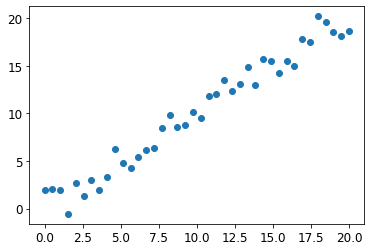

In [4]:
x_lin = torch.linspace(0,20, steps=40)
y_lin = x_lin + torch.randn_like(x_lin)
plt.scatter(x_lin, y_lin);

In [5]:
xs_lin = x_lin.unsqueeze(1)
x_lin.shape, xs_lin.shape

(torch.Size([40]), torch.Size([40, 1]))

In [6]:
x_lin[:,None].shape

torch.Size([40, 1])

In [7]:
m_lin=RandomForestRegressor().fit(xs_lin[:30],y_lin[:30])

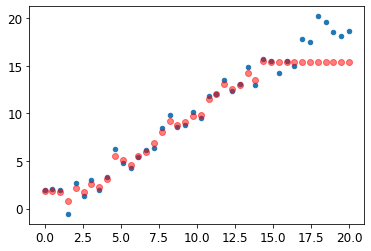

In [8]:
plt.scatter(x_lin, y_lin, 20)
plt.scatter(x_lin, m_lin.predict(xs_lin), color='red', alpha=0.5)

In [20]:
path = Path.cwd()/'bluebook-for-bulldozers'

xs_final = (path/'xs_final.pkl').load()
valid_xs_final = (path/'valid_xs_final.pkl').load()

to = (path/'to.pkl').load()
xs,y = to.train.xs, to.train.y
valid_xs, valid_y = to.valid.xs, to.valid.y

In [22]:
def rf(xs, y, n_estimators=40, max_samples=200_000,
       max_features=0.5, min_samples_leaf=5, **kwargs):
    return RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators,
        max_samples=max_samples, max_features=max_features,
        min_samples_leaf=min_samples_leaf, oob_score=True).fit(xs, y)

def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}).sort_values('imp', ascending=False)

def r_mse(pred,y): return round(math.sqrt(((pred-y)**2).mean()), 6)
def m_rmse(m, xs, y): return r_mse(m.predict(xs), y)

In [18]:
df_dom=pd.concat([xs_final,valid_xs_final])
is_valid = np.array([0]*len(xs_final) + [1]*len(valid_xs_final))

m = rf(df_dom, is_valid)
rf_feat_importance(m,df_dom)[:6]

,cols,imp
6,saleElapsed,0.546682
18,saleDayofyear,0.336825
11,SalesID,0.080769
12,MachineID,0.033553
8,Enclosure,0.000753
9,fiModelDesc,0.000463


In [23]:
m = rf(xs_final, y)
print('orig', m_rmse(m, valid_xs_final, valid_y))

for c in ('SalesID', 'saleElapsed', 'MachineID', 'saleDayofyear'):
    m = rf(xs_final.drop(c, axis=1), y)
    print(c, m_rmse(m, valid_xs_final.drop(c, axis=1), valid_y))

orig 0.236801
SalesID 0.234963
saleElapsed 0.240616
MachineID 0.234058
saleDayofyear 0.233268


In [24]:
time_vars = ['SalesID', 'MachineID','saleDayofyear']
xs_final_time = xs_final.drop(time_vars, axis=1)
valid_xs_time = valid_xs_final.drop(time_vars, axis=1)

m=rf(xs_final_time,y)
m_rmse(m, valid_xs_time, valid_y)

0.233317

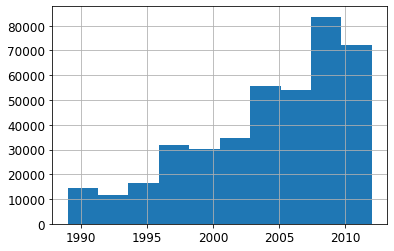

In [25]:
xs['saleYear'].hist();

In [26]:
filt = xs['saleYear']>2004
xs_filt = xs_final_time[filt]
y_filt = y[filt]

In [27]:
m = rf(xs_filt, y_filt)
m_rmse(m, xs_filt, y_filt), m_rmse(m, valid_xs_time, valid_y)

(0.176691, 0.229691)

In [29]:
df_nn = pd.read_csv(path/'TrainAndValid.csv', low_memory=False)

df_nn['ProductSize'] = df_nn['ProductSize'].astype('category')
sizes = 'Large','Large / Medium','Medium','Small','Mini','Compact'
df_nn['ProductSize'].cat.set_categories(sizes, ordered=True, inplace=True)

dep_var = 'SalePrice'
df_nn[dep_var]=np.log(df_nn[dep_var])

In [32]:
fld = df_nn['saledate']
fld_dtype = fld.dtype
if isinstance(fld_dtype, pd.core.dtypes.dtypes.DatetimeTZDtype):
        fld_dtype = np.datetime64
if not np.issubdtype(fld_dtype, np.datetime64):
        df_nn['saledate'] = fld = pd.to_datetime(fld, infer_datetime_format=True)
targ_pre = re.sub('[Dd]ate$', '', 'saledate')
drop=True
attr = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear',
            'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']
    
for n in attr: df_nn[targ_pre + n] = getattr(fld.dt, n.lower())
df_nn[targ_pre + 'Elapsed'] = fld.astype(np.int64) // 10 ** 9
if drop: df_nn.drop('saledate', axis=1, inplace=True)
#df_nn.columns

KeyError: 'saledate'

In [34]:
df_nn_final = df_nn[list(xs_final_time.columns) + [dep_var]]

In [41]:
cont_nn,cat_nn = cont_cat_split(df_nn_final, max_card=9000, dep_var=dep_var)

In [42]:
cont_nn.append('saleElapsed')
cat_nn.remove('saleElapsed')
#cat_nn.remove('Track_Type')

In [43]:
df_nn_final[cat_nn].nunique()

YearMade                73
Coupler_System           2
ProductSize              6
fiProductClassDesc      74
ModelID               5281
Hydraulics_Flow          3
fiSecondaryDesc        177
Enclosure                6
fiModelDesc           5059
fiModelDescriptor      140
ProductGroup             6
Drive_System             4
Tire_Size               17
Hydraulics              12
dtype: int64

In [45]:
xs_filt2 = xs_filt.drop('fiModelDescriptor', axis=1)
valid_xs_time2 = valid_xs_time.drop('fiModelDescriptor', axis=1)

m2 = rf(xs_filt2, y_filt)
m_rmse(m2, xs_filt2, y_filt), m_rmse(m2, valid_xs_time2, valid_y)  #accuracy after saleYear>2004 was (0.176691, 0.229691)

(0.17867, 0.23194)

In [46]:
cat_nn.remove('fiModelDescriptor')

In [63]:
procs_nn = [Categorify, FillMissing, Normalize]

In [67]:
to_nn = TabularPandas(df_nn_final, procs_nn, cat_nn, cont_nn,
                      splits=splits, y_names=dep_var)

NameError: name 'splits' is not defined

In [52]:
dls = to_nn.dataloaders(1024)

In [53]:
y = to_nn.train.y
y.min(), y.max()

(8.465899897028686, 11.863582336583399)

In [54]:
learn = tabular_learner(dls, y_range=(8,12), layers=[500,250],
                        n_out=1, loss_func=F.mse_loss)

SuggestedLRs(lr_min=0.0033113110810518267, lr_steep=0.00015848931798245758)

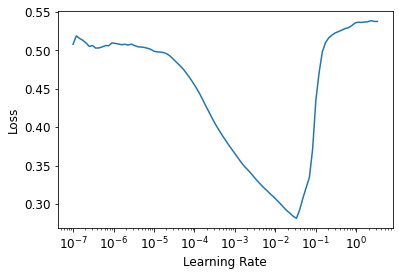

In [55]:
learn.lr_find()

In [65]:
learn.fit_one_cycle(5, 1e-2)

epoch,train_loss,valid_loss,time
0,0.057552,None,00:49
1,0.052277,None,00:49
2,0.046463,None,00:49
3,0.042827,None,00:49
4,0.039919,None,00:49


In [66]:
preds,targs = learn.get_preds()
r_mse(preds,targs)  #RandomForest accuracy was 0.23435

IndexError: list index out of range

In [68]:
learn.save('nn')

In [76]:
#preds = np.stack([t.predict(valid_xs) for t in m.estimators_])

In [74]:
#rf_preds = m.predict(valid_xs_time)
#ens_preds = (to_np(preds.squeeze()) + rf_preds) /2

In [73]:
#r_mse(ens_preds,valid_y)